# Critical Length Coupling and Flow Rate Calculations for SW Greenland
Jonathan Maurer

### Use Measures, Bedmachine Greenland, and model results from Icepack to generate maps of:

(1) $ \lambda_c = 2\pi \sqrt{\frac{4H\eta}{\beta}} $

(2) $ \gamma_o = (\frac{2\pi}{\lambda_c})^2 \cdot \frac{uH}{\alpha}$

### Where:
- H = Thickness map (meters)

- $ \eta = \frac{1}{2}A^\frac{-1}{n}|\dot{\epsilon}|^\frac{1}{n-1} $ --> Nonlinear

- $ \beta = C|u|^\frac{1}{n-1}$ (pa / (m/s)) --> Weertman 

- $ \alpha $ = surface slope (map, calc)

In [1]:
import pathlib
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
import subprocess
import geojson
import xarray
import rasterio
import firedrake
from firedrake import Constant, sqrt, exp, ln, max_value, inner, grad, dx, sym, tr
import icepack

## Load in outline and generate a mesh

In [2]:
name = "fred-enlarged-out2"

with open(f"{name}.geojson", "r") as outline_file:
    outline = geojson.load(outline_file)

geometry = icepack.meshing.collection_to_geo(outline)
with open(f"{name}.geo", "w") as geometry_file:
    geometry_file.write(geometry.get_code())

command = f"gmsh -2 -format msh2 -v 0 -o {name}.msh {name}.geo"
subprocess.run(command.split())

mesh = firedrake.Mesh(f"{name}.msh")

In [3]:
mesh_hierarchy = firedrake.MeshHierarchy(mesh, 1, 2)
mesh = mesh_hierarchy[-1]

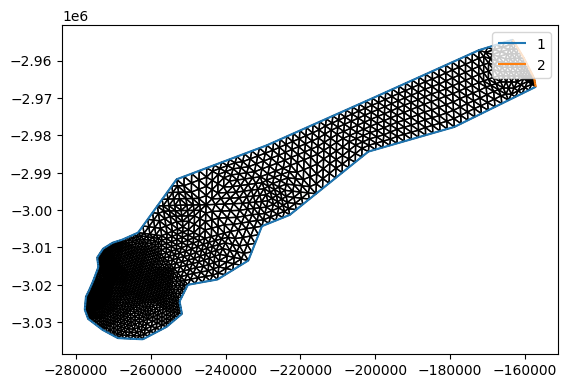

In [4]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(mesh, boundary_kw={"colors": ["tab:blue", "tab:orange"]}, axes=ax)
ax.legend();

In [5]:
cg1 = firedrake.FiniteElement("CG", "triangle", 1)
dg0 = firedrake.FiniteElement("DG", "triangle", 0)

Q = firedrake.FunctionSpace(mesh, cg1)
V = firedrake.VectorFunctionSpace(mesh, cg1)

## Load in Thickness and Bed Profiles

In [6]:
bedmachine_filename = icepack.datasets.fetch_bedmachine_greenland()
bedmachine = xarray.open_dataset(bedmachine_filename)

b = icepack.interpolate(bedmachine["bed"], Q)

h_obs = icepack.interpolate(bedmachine["thickness"], Q)
h_min = Constant(10.0)
h = firedrake.Function(Q).interpolate(max_value(h_min, h_obs))

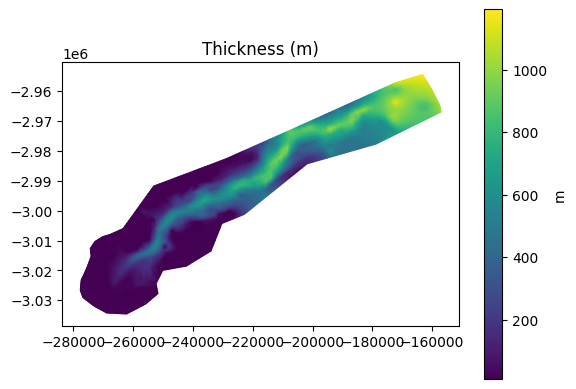

In [7]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(h, axes=ax)
fig.colorbar(colors, label="m")
ax.set_title('Thickness (m)');

In [8]:
s = firedrake.Function(Q).interpolate(b + h) # Here we define the surface as the sum of the thickness and the bed height.

## Calculate Driving Stress ($ \tau_d $)

In [9]:
from icepack.constants import ice_density, gravity
ρ = Constant(ice_density)
g = Constant(gravity)
τ_d = firedrake.Function(V)

δτ = τ_d + ρ * g * h * grad(s)
α = Constant(1e3)
J = 0.5 * (inner(δτ, δτ) + α**2 * inner(grad(τ_d), grad(τ_d))) * dx
F = firedrake.derivative(J, τ_d)
firedrake.solve(F == 0, τ_d)

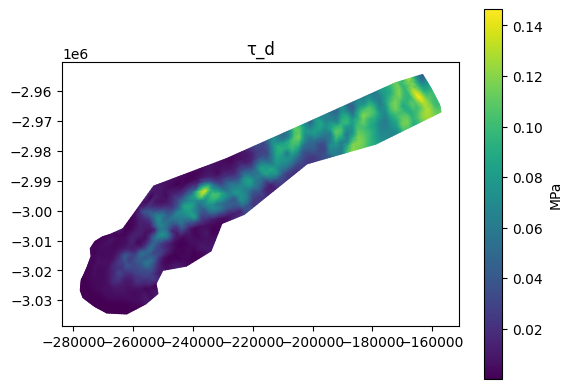

In [10]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(τ_d, axes=ax)
fig.colorbar(colors, label="MPa")
ax.set_title('τ_d');

## Load Velocity Profiles

In [11]:
velocity_filenames = icepack.datasets.fetch_measures_greenland()
vx_filename = [f for f in velocity_filenames if "vx" in f][0]
vy_filename = [f for f in velocity_filenames if "vy" in f][0]
ex_filename = [f for f in velocity_filenames if "ex" in f][0]
ey_filename = [f for f in velocity_filenames if "ey" in f][0]

In [12]:
with (rasterio.open(vx_filename, "r") as vx_file,
    rasterio.open(vy_filename, "r") as vy_file):
    u_obs = icepack.interpolate((vx_file, vy_file), V)

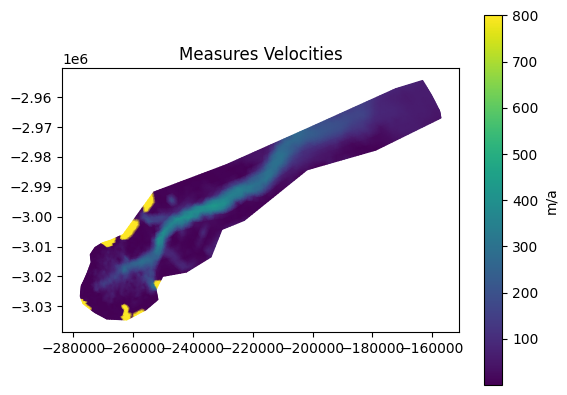

In [13]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(u_obs, vmax = 800, axes=ax)
fig.colorbar(colors, label="m/a")
ax.set_title('Measures Velocities');

## Calculate $ \beta $ from Weertman Sliding Law
 $$C = f|\tau_d| / |u|^{\frac{1}{m}}.$$
 $$ \beta = C|u|^\frac{1}{n-1}$$

In [14]:
# Calculate C
from icepack.constants import weertman_sliding_law
α = Constant(1e3)
m = Constant(weertman_sliding_law)
frac = Constant(0.8) #0.8
C_obs = frac * sqrt(inner(τ_d, τ_d)) / sqrt(inner(u_obs, u_obs)) ** (1 / m)
C = firedrake.Function(Q)

J = 0.5 * ((C - C_obs)**2 + α**2 * inner(grad(C), grad(C))) * dx
F = firedrake.derivative(J, C)
firedrake.solve(F == 0, C)

In [15]:
#Convert C to scalar 
C_scalar = sqrt(inner(C, C))

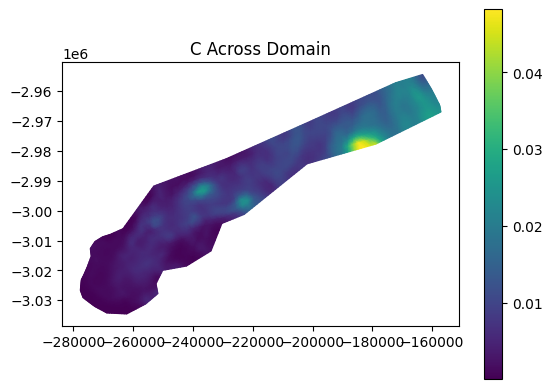

In [16]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(C, axes=ax)
fig.colorbar(colors)
ax.set_title('C Across Domain');

In [17]:
# Calculate β
β_expr = C * sqrt(inner(u_obs, u_obs)) ** (1/m-1)
β = firedrake.Function(Q).interpolate(β_expr)

In [18]:
β.dat.data_ro.min(), β.dat.data_ro.max()

(2.6912873742081145e-11, 0.03288337438169034)

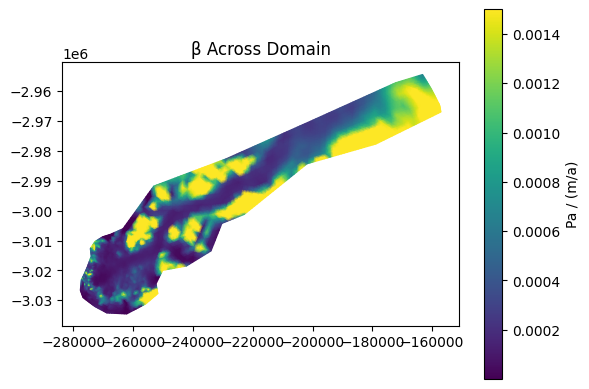

In [19]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(β, vmax = 0.0015, axes=ax)
fig.colorbar(colors, label="Pa / (m/a)")
ax.set_title('β Across Domain');

## Calculate non linear $\eta$ 
$$\eta = \frac{A^\frac{-1}{n}|\dot{\epsilon}|^\frac{1}{n-1}}{2} $$

In [20]:
# Calc ϵ_dot
Δ = firedrake.TensorFunctionSpace(mesh, "DG", 1)#, symmetry=True)
ϵ_dot_expr = sym(grad(u_obs))

ϵ_dot = firedrake.Function(Δ).project(ϵ_dot_expr)

In [21]:
# Calc Glen Rate Factor
T = Constant(272.0) #268

CS = firedrake.FunctionSpace(mesh, "R", 0)
A = firedrake.Function(CS)
A.assign(icepack.rate_factor(T))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fffb37aebc0>, FiniteElement('Real', triangle, 0), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 4)), 92)

In [22]:
n = 3
eta_expr = A ** (-1/n) * sqrt(inner(ϵ_dot, ϵ_dot)) ** (1/(n-1)) / 2

η = firedrake.Function(Q).interpolate(eta_expr)

## $\lambda_c $ Calculation

In [23]:
expr = 2 * π * ((Constant(4) * h_obs * η) / β) ** 0.5
λ_c = firedrake.Function(Q).interpolate(expr)

λ_ln = firedrake.Function(Q).interpolate(ln(sqrt(inner(λ_c , λ_c ))))

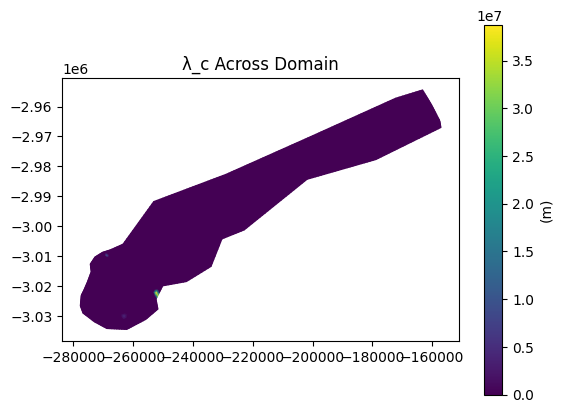

In [24]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(λ_c, axes=ax)
fig.colorbar(colors, label="(m)") # double check 
ax.set_title('λ_c Across Domain');

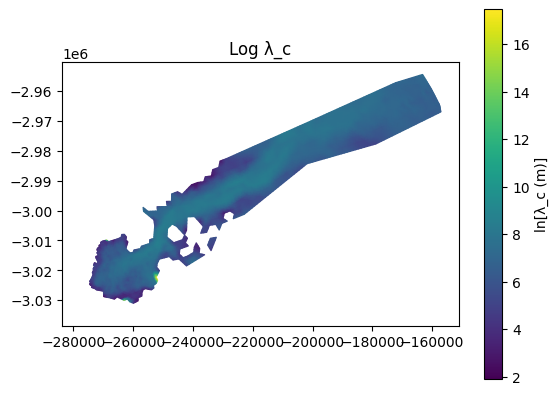

In [25]:
fig, ax = plt.subplots()

ax.set_aspect("equal")
colors = firedrake.tripcolor(λ_ln, axes=ax)
fig.colorbar(colors, label="ln[λ_c (m)]") # double check 
ax.set_title('Log λ_c');

### $ \alpha $ Calc

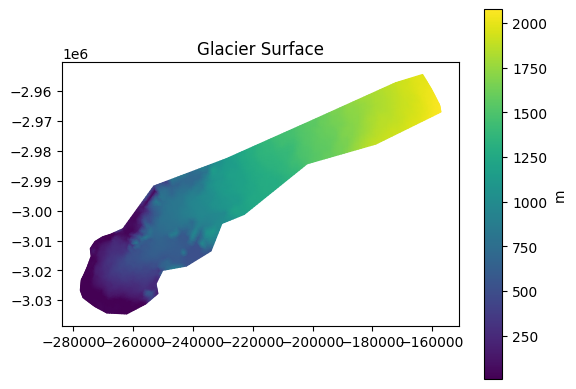

In [26]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(s, axes=ax)
fig.colorbar(colors, label="m")
ax.set_title('Glacier Surface');

In [27]:
expr = grad(s)
alpha = firedrake.Function(V).interpolate(expr)

In [28]:
# Convert to scalar
α = sqrt(inner(alpha, alpha))

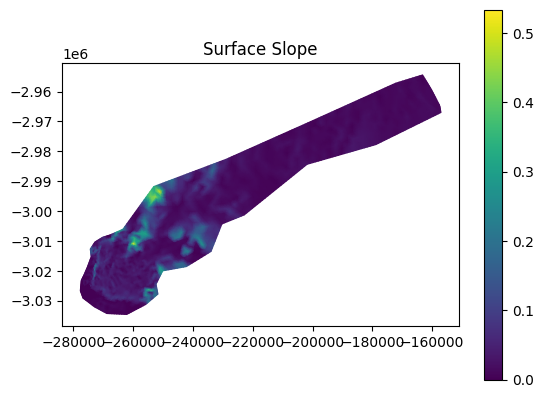

In [29]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(alpha, axes=ax)
fig.colorbar(colors)
ax.set_title('Surface Slope');

## $\gamma_o$ Calc

In [30]:
expr = (2 * π / λ_c) ** 2 * ((u_obs * h_obs) / α)
γ_o = firedrake.Function(V).interpolate(expr)

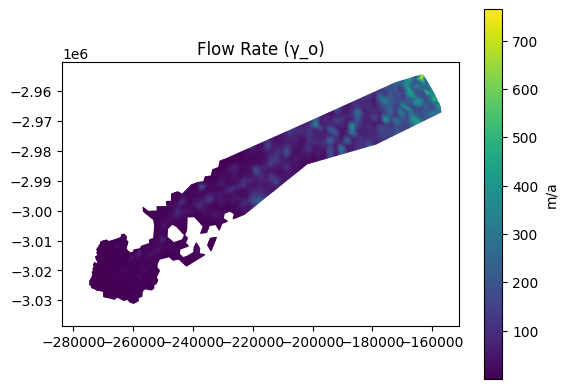

In [31]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(γ_o, axes=ax)
fig.colorbar(colors, label="m/a")
ax.set_title('Flow Rate (γ_o)');